<a href="https://colab.research.google.com/github/congltk1234/Fashion_Items_Classification/blob/main/FashionMNIST/KNN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [1]:
!pip install -U tensorflow_datasets

import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

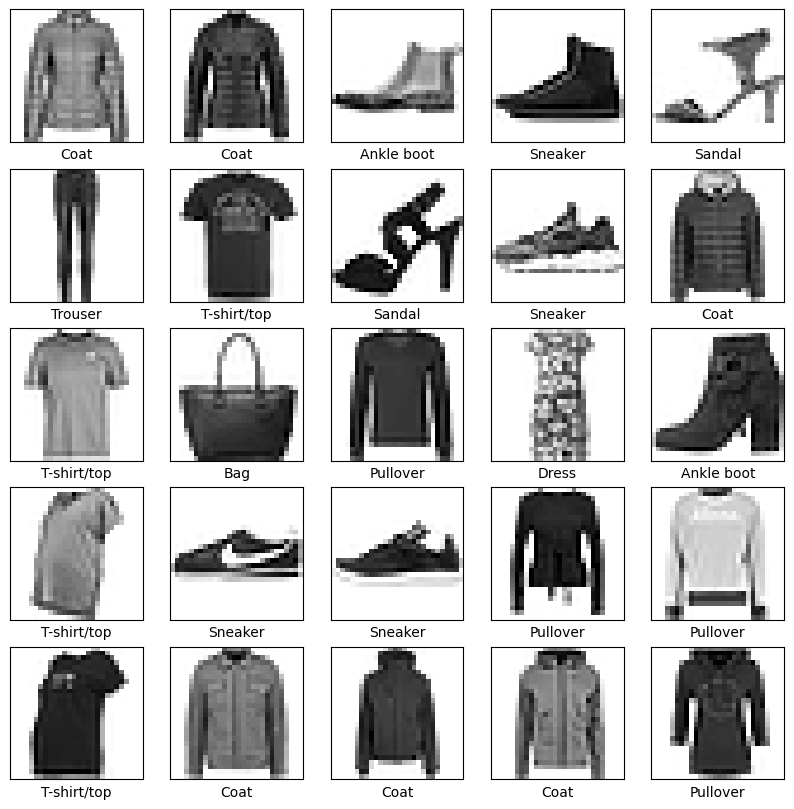

In [7]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imutils import paths
import os
import glob
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import tqdm
trainX = []
trainY = []
for (image, label) in tqdm.tqdm(test_dataset.take(10000)):
    image = image.numpy().flatten()
    trainX.append(image)
    trainY.append(label)

trainX = np.array(trainX)
trainY = np.array(trainY)

le = LabelEncoder()
trainY = le.fit_transform(trainY)
trainX.shape, trainY.shape

100%|██████████| 10000/10000 [00:05<00:00, 1702.70it/s]


((10000, 784), (10000,))

100%|██████████| 19/19 [02:15<00:00,  7.15s/it]


<Figure size 640x480 with 0 Axes>

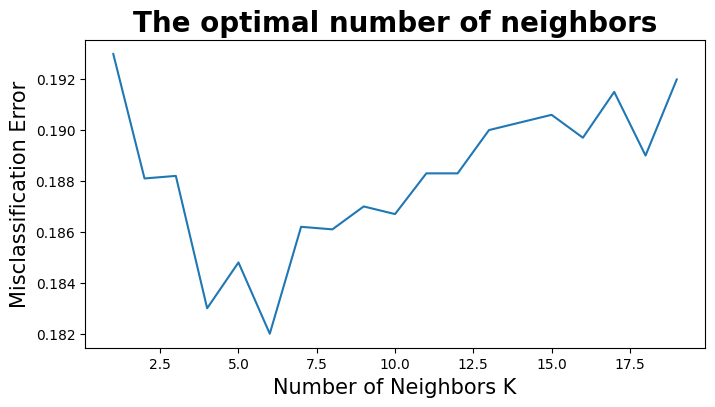

In [10]:
from sklearn.model_selection import cross_val_score

# creating list of K for KNN
k_list = list(range(1,20,1))
# creating list of cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tqdm.tqdm(k_list):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, trainX, trainY, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

plt.figure()
plt.figure(figsize=(8,4))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_list, MSE)

plt.show()

In [11]:
# finding best k
best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 6.


In [22]:
model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
model.fit(trainX, trainY)

print(classification_report(trainY, model.predict(trainX), target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.75      0.93      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.75      0.84      0.79      1000
       Dress       0.89      0.87      0.88      1000
        Coat       0.79      0.75      0.77      1000
      Sandal       0.99      0.82      0.90      1000
       Shirt       0.72      0.56      0.63      1000
     Sneaker       0.86      0.96      0.91      1000
         Bag       0.97      0.94      0.95      1000
  Ankle boot       0.90      0.95      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



<Figure size 1000x300 with 0 Axes>

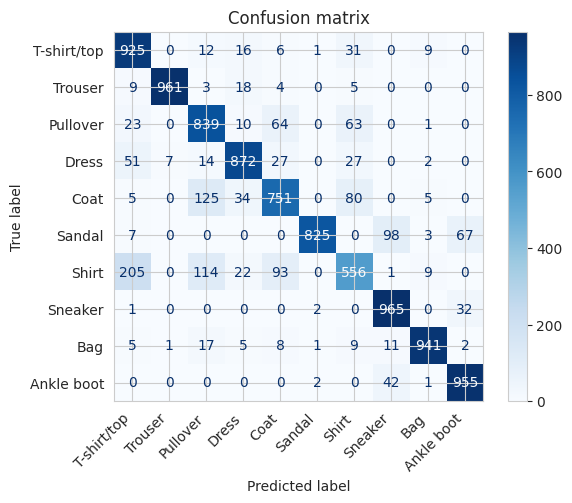

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,3))

disp = ConfusionMatrixDisplay.from_estimator(
    model,
    trainX, trainY,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion matrix")

# print(disp.confusion_matrix)
# Rotate x-axis labels
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')

plt.show()